## STEP 1: Import libraries

In [ ]:
import os
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Add, Dense, GlobalAveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt

## STEP 2: Download the dataset 

Dataset and how it was created can be read in this great Medium article: https://towardsdatascience.com/detecting-covid-19-induced-pneumonia-from-chest-x-rays-with-transfer-learning-an-implementation-311484e6afc1

In [ ]:
!gdown https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
!unzip Covid_Data_GradientCrescent.zip

Downloading...
From: https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
To: /content/Covid_Data_GradientCrescent.zip
154MB [00:01, 113MB/s] 
Archive:  Covid_Data_GradientCrescent.zip
   creating: all/
   creating: all/test/
   creating: all/test/covid/
  inflating: all/test/covid/nejmoa2001191_f3-PA.jpeg  
  inflating: all/test/covid/nejmoa2001191_f4.jpeg  
  inflating: all/test/covid/nejmoa2001191_f5-PA.jpeg  
  inflating: all/test/covid/radiol.2020200490.fig3.jpeg  
  inflating: all/test/covid/ryct.2020200028.fig1a.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig2.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day0.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day4.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day7.jpeg  
   creating: all/test/normal/
  inflating: all/test/normal/NORMAL2-IM-1385-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1396-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1400-0001.jpeg  
  inflating: all

In [ ]:
# Specify training data directory
four_class_training_dir = 'all/train'

In [ ]:
# List the folders in the directory
os.listdir(four_class_training_dir)

['covid', 'pneumonia_bac', 'normal', 'pneumonia_vir']

## STEP 3: Create ImageDataGenerator


If you want to include data augmentation to your image scaller here is an example:
```
image_generator = ImageDataGenerator(rescale = 1./255, 
                                     rotation_range=50,
                                    featurewise_center = True,
                                    featurewise_std_normalization = True,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.25,
                                    zoom_range=0.1,
                                    zca_whitening = True,
                                    channel_shift_range = 20,
                                    horizontal_flip = True ,
                                    vertical_flip = True ,
                                    validation_split = 0.1
                                    fill_mode='constant')

```
A few example used to augment data:

**rescale** - normalizes pixel values to be between 0 and 1

**rotation_range** - sets rotation angle 

**featurewise_center** -  set input mean to 0 over the dataset

**featurewise_std_normalization** - divide inputs by std of the dataset

**shear_range** - shear angle in counter-clockwise direction in degrees

<br><br>

Besides augmentation we are using **validation_split** of 10%.

In [ ]:
image_generator = ImageDataGenerator(rescale = 1./255, 
                                    validation_split = 0.1)

In [ ]:
train_generator = image_generator.flow_from_directory(batch_size = 35, 
                                                      directory=four_class_training_dir, 
                                                      shuffle= True, 
                                                      target_size=(224,224), 
                                                      class_mode = 'categorical', 
                                                      subset="training")

Found 243 images belonging to 4 classes.


In [ ]:
validation_generator = image_generator.flow_from_directory(batch_size = 35, 
                                                           directory= four_class_training_dir, 
                                                           shuffle= True, target_size=(256,256),
                                                           class_mode = 'categorical', 
                                                           subset="validation")

Found 27 images belonging to 4 classes.


In [ ]:
class_names_mapper = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Bacterial Pneumonia', 3 : 'Pneumonia Viral'}

### Let's check out what data we have

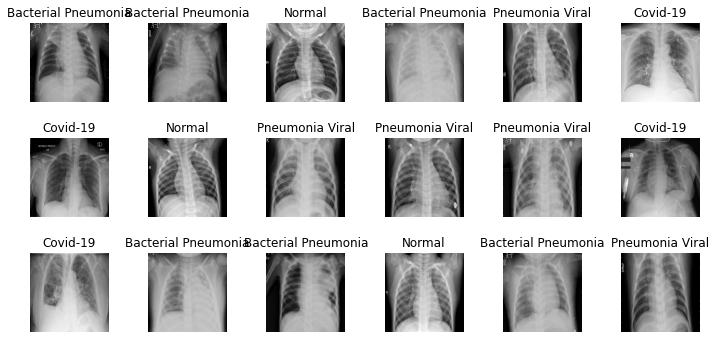

In [ ]:
images, labels = next(train_generator)
L = 3
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 6))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(images[i])
    axes[i].set_title(class_names_mapper[np.argmax(labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)    

## STEP 4: Load our pre trained MobileNet v2

In [ ]:
mobile_net = MobileNetV2(weights='imagenet', 
                         include_top = False, 
                         input_shape=(224, 224, 3))

In [ ]:
mobile_net.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
# Lets freeze the whole base model (in our case MobileNet v1)
mobile_net.trainable = False

## STEP 5: Create a head part of the model

In [ ]:
head_network = mobile_net.output
head_network = GlobalAveragePooling2D()(head_network)
head_network = Dense(256, activation = "relu")(head_network)
head_network = Dropout(0.4)(head_network)
head_network = Dense(4, activation = 'softmax')(head_network)

model = Model(inputs = mobile_net.input, outputs = head_network)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer=optimizers.RMSprop(lr = 0.0001, decay = 1e-6), 
              metrics= ["accuracy"])

In [ ]:
# Use early stopping as a safety net so our net is not overfitted
early_stopping_callback_obj = EarlyStopping(monitor='val_loss', 
                                            mode='min', 
                                            verbose=1, 
                                            patience=20)

# Create Checkpointer that saves the model based on the validation loss
model_saver = ModelCheckpoint(filepath="covid19net.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit_generator(train_generator, 
                            epochs = 10,
                            steps_per_epoch= train_generator.n // 4,
                            validation_data=validation_generator,
                            validation_steps= validation_generator.n // 4,
                            callbacks=[model_saver, early_stopping_callback_obj],
                            verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
60/60 [==============================] - ETA: 0s - loss: 0.9205 - accuracy: 0.6206
Epoch 00001: val_loss improved from inf to 0.79931, saving model to covid19net.hdf5
60/60 [==============================] - 36s 600ms/step - loss: 0.9205 - accuracy: 0.6206 - val_loss: 0.7993 - val_accuracy: 0.5926
Epoch 2/10
60/60 [==============================] - ETA: 0s - loss: 0.4905 - accuracy: 0.8297
Epoch 00002: val_loss improved from 0.79931 to 0.70942, saving model to covid19net.hdf5
60/60 [==============================] - 35s 576ms/step - loss: 0.4905 - accuracy: 0.8297 - val_loss: 0.7094 - val_accuracy: 0.7037
Epoch 3/10
60/60 [==============================] - ETA: 0s - loss: 0.3382 - accuracy: 0.8991
Epoch 00003: val_loss improved from 0.70942 to 0.62551, saving model to covid19net.hdf5
60/60 [==============================] - 34s 575ms/step - loss: 0.3382 - accuracy: 0.8991 - val_loss: 0.6255 - val_acc


## STEP 6: Test the model on the test dataset

In [ ]:
test_directory = 'all/test'

In [ ]:
test_img_generator = ImageDataGenerator(rescale = 1./255)

test_generator = test_img_generator.flow_from_directory(batch_size = 35, 
                                              directory= test_directory, 
                                              shuffle= True,
                                              target_size=(224,224), 
                                              class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, 
                                    steps= test_generator.n // 4,
                                    verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 36 images belonging to 4 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
9/9 [==============================] - 3s 279ms/step - loss: 0.5821 - accuracy: 0.7207
Accuracy Test : 0.7206704020500183
